<a href="https://colab.research.google.com/github/sushmitharamk/computervision/blob/main/LeNet5_FashionMNIST_batchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LeNet5 Archiecture with BatchNorm**

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

# To set the environment variables import os
import os

# to monitor the training or validation time
import time
from typing import Iterable

# Dataset
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms


In [3]:
###### LeNet Architecture ########

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self._body = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels= 6, kernel_size = 5),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.ReLU(inplace =True),
        nn.MaxPool2d(kernel_size =2),
    )

    # fully connected layers
    self._head = nn.Sequential(
        nn.Linear(in_features = 16 * 5 * 5, out_features = 120),
        nn.ReLU(inplace =True),
        nn.Linear(in_features = 120, out_features = 84),
        nn.ReLU(inplace = True),
        nn.Linear(in_features = 84, out_features =10)
    )

  def forward(self, x):
    x = self._body(x)
    x = x.view(x.size()[0], -1)
    x = self._head(x)
    return x

In [4]:
class LeNetBN(nn.Module):
  def __init__(self):
    super().__init__()

    self._body = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5),
        nn.BatchNorm2d(6),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2),

    )

    self._head = nn.Sequential(
        nn.Linear(in_features = 16*5*5, out_features = 120),
        nn.ReLU(inplace = True),

        nn.Linear(in_features = 120, out_features = 84),
        nn.ReLU(inplace = True),

        nn.Linear(in_features = 84, out_features = 10)
    )


  def forward(self, x):
    x  = self._body(x)
    x = x.view(x.size()[0],-1)
    x = self._head(x)
    return x

In [5]:
lenet_model = LeNet()
print(lenet_model)
print("################################################################")
lenetBN_model = LeNetBN()
print(lenetBN_model)

LeNet(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
################################################################
LeNetBN(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

In [6]:
def get_data(batch_size, data_root= 'data', num_workers = 1):

  train_test_transforms = transforms.Compose([
      transforms.Resize((32,32)),
      transforms.ToTensor(),
      transforms.Normalize((0.2860,), (0.3530,))
  ])

  train_loader = torch.utils.data.DataLoader(
      datasets.FashionMNIST(root = data_root, train = True, download = True, transform= train_test_transforms),
      batch_size = batch_size,
      shuffle = True,
      num_workers = num_workers
  )

  test_loader = torch.utils.data.DataLoader(
      datasets.FashionMNIST(root=data_root, train = False, download = False, transform = train_test_transforms),
      batch_size = batch_size,
      shuffle = False,
      num_workers = num_workers
  )
  return train_loader, test_loader

In [7]:
@dataclass
class SystemConfiguration:
  seed: int = 42
  cudnn_benchmark_enabled: bool = True
  cudnn_deterministic: bool = True

In [8]:
@dataclass
class TrainingConfiguration:
  batch_size: int =32
  epochs_count: int = 20
  learning_rate: float = 0.01
  log_interval: int =100
  test_interval: int = 1
  data_root: str = "data"
  num_workers: int=10
  device: str = 'cuda'

In [9]:
def setup_system(system_config: SystemConfiguration) -> None:
  torch.manual_seed(system_config.seed)
  if torch.cuda.is_available():
    torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
    torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [10]:
def train(
    train_config : TrainingConfiguration, model : nn.Module, optimizer: torch.optim.Optimizer,
    train_loader : torch.utils.data.DataLoader, epoch_idx: int
    ) -> None:
  model.train()
  batch_loss = np.array([])
  batch_acc = np.array([])

  for batch_idx, (data,target) in enumerate(train_loader):
    indx_target = target.clone()
    data = data.to(train_config.device)
    target = target.to(train_config.device)
    optimizer.zero_grad()

    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    batch_loss = np.append(batch_loss, [loss.item()])

    prob = F.softmax(output, dim=1)
    pred = prob.data.max(dim=1)[1]

    correct = pred.cpu().eq(indx_target).sum()

    acc = float(correct) / float(len(data))

    batch_acc = np.append(batch_acc,[acc])

    if batch_idx % train_config.log_interval ==0 and batch_idx >0 :
      print(
          'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
              epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
          )
      )

      epoch_loss = batch_loss.mean()
      epoch_acc = batch_acc.mean()
      return epoch_loss, epoch_acc


In [11]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    #
    model.eval()
    test_loss = 0
    count_corect_predictions = 0

    with torch.no_grad():
        for data, target in test_loader:
            indx_target = target.clone()
            data = data.to(train_config.device)

            target = target.to(train_config.device)

            output = model(data)
            # add loss for each mini batch
            test_loss += F.cross_entropy(output, target).item()

            # get probability score using softmax
            prob = F.softmax(output, dim=1)

            # get the index of the max probability
            pred = prob.data.max(dim=1)[1]

            # add correct prediction count
            count_corect_predictions += pred.cpu().eq(indx_target).sum()

        # average over number of mini-batches
        test_loss = test_loss / len(test_loader)

        # average over number of dataset
        accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

        print(
            '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
            )
        )
    return test_loss, accuracy/100.0

In [12]:
def main(model, system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):

    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config,
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 10

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )

    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)

    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])

    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):

        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)

        epoch_train_loss = np.append(epoch_train_loss, [train_loss])

        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time

        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)

            epoch_test_loss = np.append(epoch_test_loss, [current_loss])

            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])

            if current_loss < best_loss:
                best_loss = current_loss

    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [13]:
model = LeNet()
modelBN = LeNetBN()

model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main(model)

modelBN, epoch_train_loss_bn, epoch_train_acc_bn, epoch_test_loss_bn, epoch_test_acc_bn = main(modelBN)

100%|██████████| 26421880/26421880 [00:08<00:00, 3083241.86it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267887.61it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 810196.80it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1616793.48it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Train Epoch: 0 [1600/60000] Loss: 2.292552 Acc: 0.1250
Elapsed 3.28s, 3.28 s/epoch, 0.00 s/batch, ets 29.50s

Test set: Average loss: 2.2958, Accuracy: 1287/10000 (13%)

Train Epoch: 1 [1600/60000] Loss: 2.287451 Acc: 0.0625
Elapsed 15.36s, 7.68 s/epoch, 0.00 s/batch, ets 61.46s

Test set: Average loss: 2.2840, Accuracy: 1464/10000 (15%)

Train Epoch: 2 [1600/60000] Loss: 2.272932 Acc: 0.0625
Elapsed 21.83s, 7.28 s/epoch, 0.00 s/batch, ets 50.93s

Test set: Average loss: 2.2529, Accuracy: 1579/10000 (16%)

Train Epoch: 3 [1600/60000] Loss: 2.200012 Acc: 0.2500
Elapsed 29.70s, 7.42 s/epoch, 0.00 s/batch, ets 44.55s

Test set: Average loss: 2.0844, Accuracy: 2820/10000 (28%)

Train Epoch: 4 [1600/60000] Loss: 1.590057 Acc: 0.4375
Elapsed 36.70s, 7.34 s/epoch, 0.00 s/batch, ets 36.70s

Test set: Average loss: 1.4486, Accuracy: 5054/10000 (51%)

Train Epoch: 5 [1600/60000] Loss: 1.080169 Acc: 0.6250
Elapse

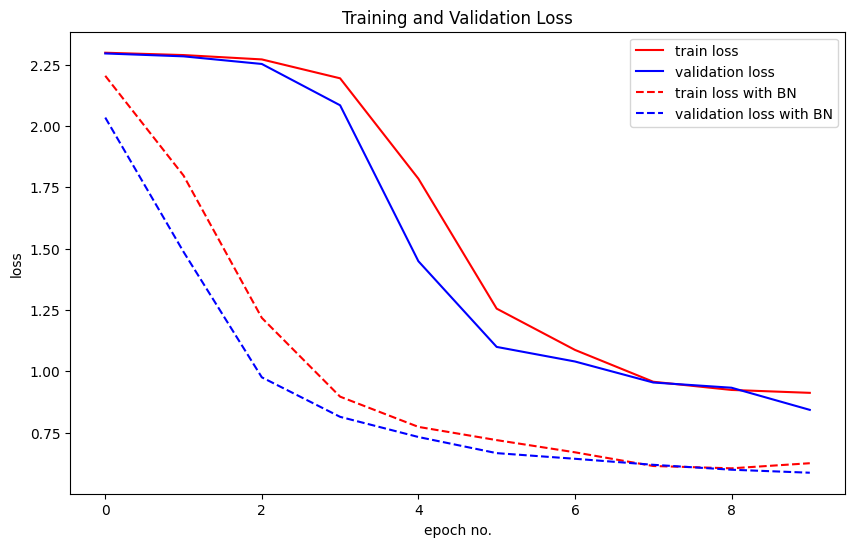

In [14]:
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, 'r', label="train loss")
plt.plot(x, epoch_test_loss, 'b', label="validation loss")

plt.plot(x, epoch_train_loss_bn, 'r--', label="train loss with BN")
plt.plot(x, epoch_test_loss_bn, 'b--',label="validation loss with BN")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
import torchvision
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transform)

print(train_set.data.float().mean()/255)
print(train_set.data.float().std()/255)

tensor(0.2860)
tensor(0.3530)
